In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium 

In [2]:
connection = sqlite3.connect('C:/Users/SAMIR/Desktop/database/LABdb.db') 

##                                         Medical Lab Database
This database was designed for a medical laboratory. The data was generated using fake information obtained from https://www.mockaroo.com/ especially for this project

In [3]:
pd.options.display.max_columns = 10

First I will explore the tables in the database to decide which tables I will use in my analysis 

In [4]:
pd.read_sql("SELECT name as Tables FROM sqlite_master WHERE type='table';", connection)

,Tables
0,CLIENTS
1,INSURANCES
2,PATIENTS
3,PHLEBOTOMISTS
4,TESTS
5,COMMENTS
6,REQUISITIONS
7,INVOICES


Used head() function to display the first few rows of each table

In [5]:
#pd.read_sql("SELECT * FROM CLIENTS;", connection).head()
#pd.read_sql("SELECT * FROM INSURANCES;", connection).head()
pd.read_sql("SELECT * FROM PATIENTS;", connection).head()
#pd.read_sql(f"SELECT * FROM PHLEBOTOMISTS;", connection).head()
#pd.read_sql("SELECT * FROM TESTS;", connection).head()
#pd.read_sql("SELECT * FROM COMMENTS;", connection).head()
#pd.read_sql("SELECT * FROM REQUISITIONS;", connection).head()
#pd.read_sql("SELECT * FROM INVOICES;", connection).head()


,PATIENTID,FIRSTNAME,LASTNAME,SEX,AGE,...,ZIPCODE,TELEPHONE,EMAIL,INSURANCEID,POLICYNO
0,1,Leroi,Snel,Male,6,...,10705,914-600-9925,lsnel0@icio.us,12,2W25AN8KW77
1,2,Junette,Cullagh,Female,40,...,20195,703-302-1378,jcullagh1@theguardian.com,30,7UW7WK2PH47
2,3,Humphrey,Byrcher,Male,47,...,10160,212-464-5431,hbyrcher2@shutterfly.com,29,9DV2J86CR96
3,4,Jelene,McVrone,Female,37,...,25716,304-537-8557,jmcvrone3@vistaprint.com,30,6K41FH6FJ72
4,5,Ashlin,Renac,Male,38,...,11024,516-183-7099,arenac4@opera.com,21,4XE9FQ2VD87


### My analysis will be divided into two sections:
#### The first section will focus on utilizing the database to enhance internal organizational operations (LAB), 
#### while the second section will highlight its relevance for external audiences.

# First Section: 

#### Assuming that the organization (LAB) wants to check its employees (PHLEBOTOMISTS) performance and identify the employee of the year

In [6]:
PP=pd.read_sql('''

        SELECT FIRSTNAME || ' ' || LASTNAME AS NAME, ph.PHLEBOTOMISTID, COUNT(r.PHLEBOTOMISTID) AS COUNT_PHLEBOTOMISTID
        FROM REQUISITIONS r JOIN PHLEBOTOMISTS ph ON r.PHLEBOTOMISTID = ph.PHLEBOTOMISTID 
        WHERE TERMINATION_DATE IS NULL AND COLLECTION_DATE BETWEEN '2023-01-01' AND '2023-12-31'
        GROUP BY FIRSTNAME, LASTNAME,ph.PHLEBOTOMISTID
        ORDER BY ph.PHLEBOTOMISTID
;''', connection)


#### I used the REQUISITIONS and PHLEBOTOMISTS tables to determine the number of patients that each phlebotomist served over the year, I also filtered this selection to include only current employees by using "WHERE TERMINATION_DATE IS NULL" statement 

In [7]:
pd.read_sql('''

        SELECT FIRSTNAME || ' ' || LASTNAME AS NAME, ph.PHLEBOTOMISTID, COUNT(r.PHLEBOTOMISTID) AS COUNT_PHLEBOTOMISTID
        FROM REQUISITIONS r JOIN PHLEBOTOMISTS ph ON r.PHLEBOTOMISTID = ph.PHLEBOTOMISTID 
        WHERE TERMINATION_DATE IS NULL AND COLLECTION_DATE BETWEEN '2023-01-01' AND '2023-12-31'
        GROUP BY FIRSTNAME, LASTNAME,ph.PHLEBOTOMISTID
        ORDER BY ph.PHLEBOTOMISTID
;''', connection).head()

,NAME,PHLEBOTOMISTID,COUNT_PHLEBOTOMISTID
0,Tuck Korfmann,1,2
1,Mahalia Gadson,10,1
2,Merrel Doog,11,1
3,Charley Toomey,12,1
4,Doloritas Bockh,13,2


#### From that output I generated a bar chart to visually represent the data
## EMPOLYEE (PHLEBOTOMIST) OF THE YEAR 

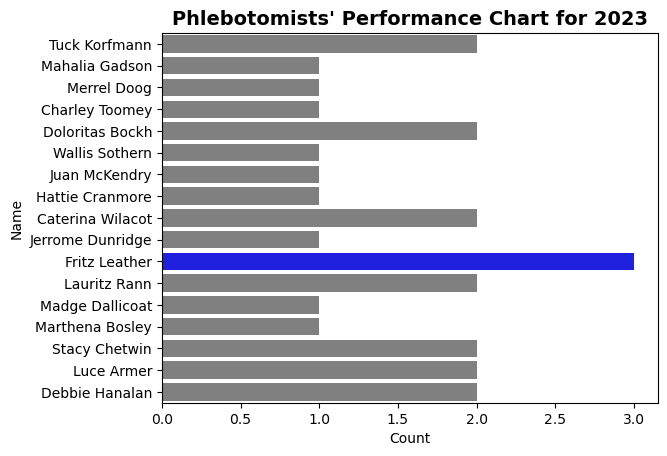

In [8]:
# index of the highest value
Top = PP['COUNT_PHLEBOTOMISTID'].idxmax()
# Define color palette
colors = ['grey' if i != Top else 'blue' for i in range(len(PP))]
plt.figure()
sns.barplot(x='COUNT_PHLEBOTOMISTID', y='NAME', data=PP,palette=colors)
plt.title("Phlebotomists' Performance Chart for 2023", fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Name')
plt.savefig('C:/Users/SAMIR/Desktop/database/Phlebotomist performance chart for 2023.png', bbox_inches='tight')
plt.show()

#### Another approach to determine the name and ID of the Phlebotomist of the Year 

In [9]:
pd.read_sql('''
SELECT FIRSTNAME || ' ' || LASTNAME AS EMPLOYEE_OF_THE_YEAR,PHLEBOTOMISTID 
FROM PHLEBOTOMISTS 
WHERE PHLEBOTOMISTID = (
    SELECT PHLEBOTOMISTID 
    FROM (
        SELECT PHLEBOTOMISTID, COUNT(PHLEBOTOMISTID) 
        FROM REQUISITIONS 
        WHERE COLLECTION_DATE BETWEEN '2023-01-01' AND '2023-12-31' 
        GROUP BY PHLEBOTOMISTID 
        ORDER BY COUNT(PHLEBOTOMISTID) DESC 
        LIMIT 1
    ) AS IDK
)''', connection,index_col=['PHLEBOTOMISTID'] )


,EMPLOYEE_OF_THE_YEAR
PHLEBOTOMISTID,
2,Fritz Leather


#### After identifying the Phlebotomist of the Year, I conducted an additional analysis to review his/her performance throughout the year

In [10]:
performance=pd.read_sql('''
        SELECT  strftime('%m', COLLECTION_DATE) AS MONTH ,COUNT(PHLEBOTOMISTID) AS COUNT 
        FROM REQUISITIONS 
        WHERE PHLEBOTOMISTID = '21'
        GROUP BY MONTH
;''', connection)
# used the strftime function to extract the month part of the COLLECTION_DATE column in SQLite.

#### The following chart visually demonstrate the findings

C:\Users\SAMIR\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


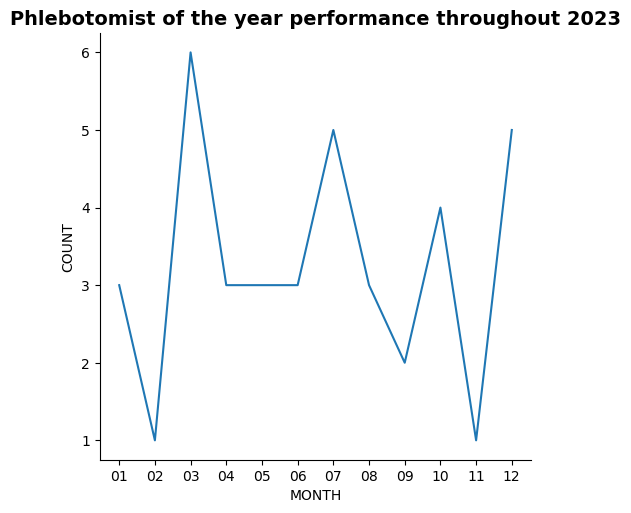

In [11]:

sns.relplot(data=performance, x='MONTH', y='COUNT', kind='line')
plt.title('Phlebotomist of the year performance throughout 2023', fontsize=14, fontweight='bold')
plt.savefig('C:/Users/SAMIR/Desktop/database/Phlebotomist of the year performance throughout 2023.png', bbox_inches='tight')
plt.show()

#### The chart indicates that the highest performance occurred in March, while the lowest performances were observed in February and November

# Second Section: 
 ## FIND PATIENTS WITHOUT INSURANCE 
 

In [12]:
ins=pd.read_sql( '''
            SELECT STATE,COUNT(PATIENTID) AS COUNT
            FROM PATIENTS
            WHERE POLICYNO IS NULL 
            GROUP BY STATE

            ''',connection)



#### I used the PATIENTS table to determine the number of patients without insurance by filtering the selection  using "WHERE POLICYNO IS NULL " and grouping the output by STATE

In [13]:
V=ins['COUNT'].tolist() # list count per state 
V

[5, 7, 1, 1, 1, 1, 2, 2, 1, 1, 9, 1, 2]

In [14]:
H = ins['COUNT'].max()
H

9

#### The following chart visually demonstrates the number of uninsured patients per state

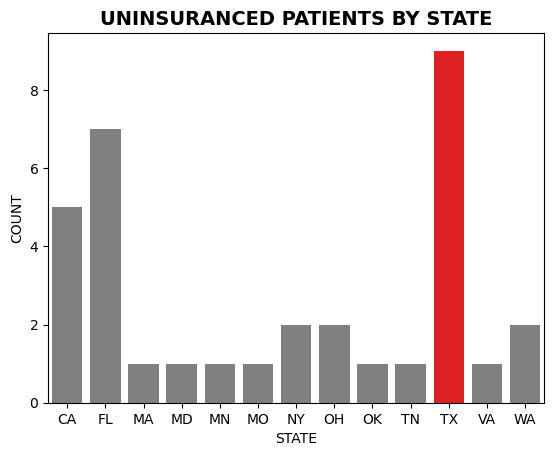

In [15]:
# highest value
H = ins['COUNT'].max()
# Define color palette
colors2 = ['grey' if i != H else 'red' for i in (ins['COUNT'].tolist())]
plt.figure()
sns.barplot(x='STATE', y='COUNT', data=ins,palette=colors2)
plt.xlabel('STATE')
plt.ylabel('COUNT')
plt.title("UNINSURANCED PATIENTS BY STATE", fontsize=14, fontweight='bold')
plt.savefig('C:/Users/SAMIR/Desktop/database/UNINSURANCED PATIENTS BY STATE.png', bbox_inches='tight')
plt.show()

#### The chart reveals that Texas has the highest number of uninsured patients

## Which state had the highest number of COVID-19 cases in 2023?
#### (POS IF RESULT >=1) and from the TEST table in the database COVID-19 TESTID = '1053' 

In [16]:

covid=pd.read_sql( '''
SELECT p.STATE,COUNT(r.PATIENTID) AS COUNT
FROM PATIENTS P JOIN REQUISITIONS r ON p.PATIENTID = r.PATIENTID
WHERE RESULT >= 1 AND TESTID = '1053'   
GROUP BY STATE;

''',connection)


#### The following chart illustrates the spread of COVID-19 infections across states

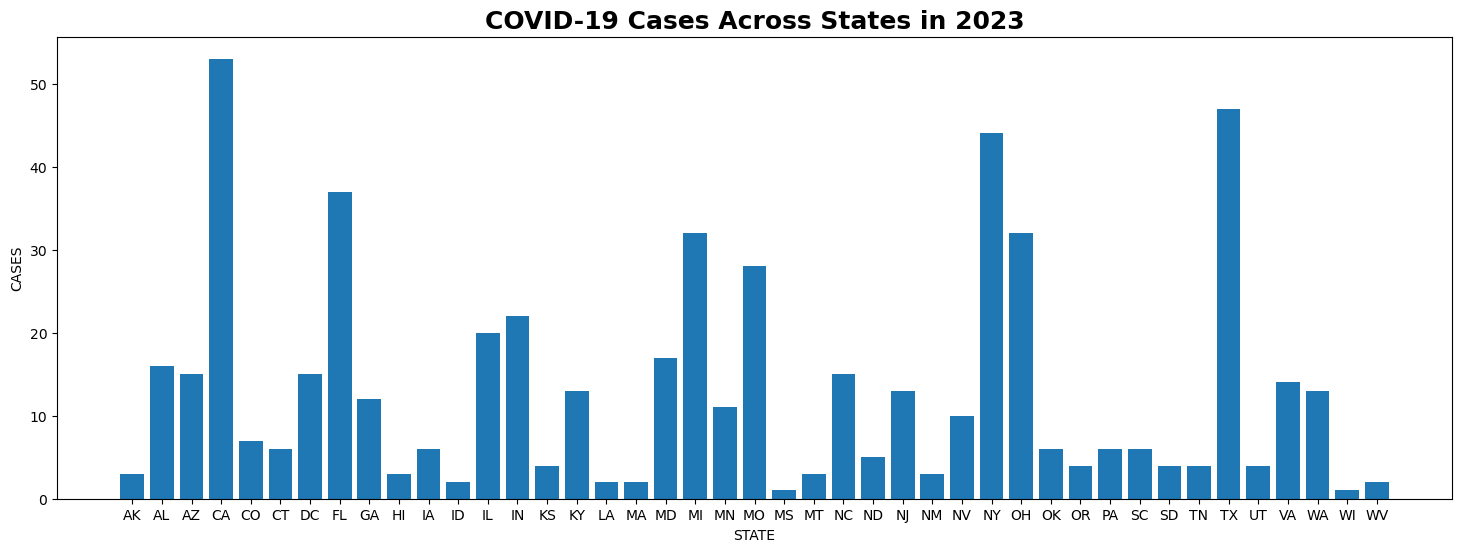

In [17]:

fig, ax = plt.subplots(figsize=(18, 6))

ax.bar(covid['STATE'], covid['COUNT'])
ax.set_xlabel('STATE')
ax.set_ylabel('CASES')
ax.set_title('COVID-19 Cases Across States in 2023', fontsize=18, fontweight='bold')
plt.savefig('C:/Users/SAMIR/Desktop/database/COVID-19 Cases Across States in 2023.png', bbox_inches='tight')
plt.show()

### California had the highest number of cases followed by Texas and then New York

#### prompt ChatGPT to generate a dictionary that includes State abbreviations paired with their locations


In [18]:
 
state_locations = { 'AL': [32.806671, -86.791130],'AK': [61.370716, -152.404419],'AZ': [33.729759, -111.431221],
    'AR': [34.969704, -92.373123],'CA': [36.7783, -119.4179],'CO': [39.059811, -105.311104],'CT': [41.597782, -72.755371],
    'DE': [39.318523, -75.507141],'FL': [27.994402, -81.760254],'GA': [33.040619, -83.643074],'HI': [21.094318, -157.498337],
    'ID': [44.240459, -114.478828],'IL': [40.349457, -88.986137],'IN': [39.849426, -86.258278],'IA': [42.011539, -93.210526],
    'KS': [38.526600, -96.726486],'KY': [37.668140, -84.670067],'LA': [31.169546, -91.867805],'ME': [44.693947, -69.381927],
    'MD': [39.063946, -76.802101],'MA': [42.230171, -71.530106],'MI': [43.326618, -84.536095],'MN': [45.694454, -93.900192],
    'MS': [32.741646, -89.678696],'MO': [38.456085, -92.288368],'MT': [46.921925, -110.454353],'NE': [41.125370, -98.268082],
    'NV': [38.313515, -117.055374],'NH': [43.452492, -71.563896],'NJ': [40.298904, -74.521011],'NM': [34.840515, -106.248482],
    'NY': [42.165726, -74.948051],'NC': [35.630066, -79.806419],'ND': [47.528912, -99.784012],'OH': [40.388783, -82.764915],
    'OK': [35.565342, -96.928917],'OR': [44.572021, -122.070938],'PA': [40.590752, -77.209755],'RI': [41.680893, -71.511780],
    'SC': [33.856892, -80.945007],'SD': [44.299782, -99.438828],'TN': [35.747845, -86.692345],'TX': [31.054487, -97.563461],
    'UT': [40.150032, -111.862434],'VT': [44.045876, -72.710686],'VA': [37.769337, -78.169968],'WA': [47.400902, -121.490494],
    'WV': [38.491226, -80.954071],'WI': [44.268543, -89.616508],'WY': [42.755966, -107.302490] }


#### Next I will use folium library to display that on a map 

In [19]:
import folium

# Create a map centered on the United States

usa_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Iterate through the COVID-19 data and add markers for each state

for index, row in covid.iterrows():
    state = row['STATE']
    count = row['COUNT']
    if state in state_locations:
        location = state_locations[state]
        # Use count as the radius
        folium.CircleMarker(location, radius=count/3,color='red',popup=state, fill=True).add_to(usa_map)

# Display the map

usa_map.save("C:/Users/SAMIR/Desktop/database/usa_covid_map.html")
usa_map

In [20]:
#covid_G=
pd.read_sql( '''
SELECT p.SEX,COUNT(r.PATIENTID) AS COUNT
FROM PATIENTS P JOIN REQUISITIONS r ON p.PATIENTID = r.PATIENTID
WHERE RESULT >= 1 AND TESTID = '1053'
GROUP BY SEX;

''',connection)

,SEX,COUNT
0,Female,263
1,Male,300


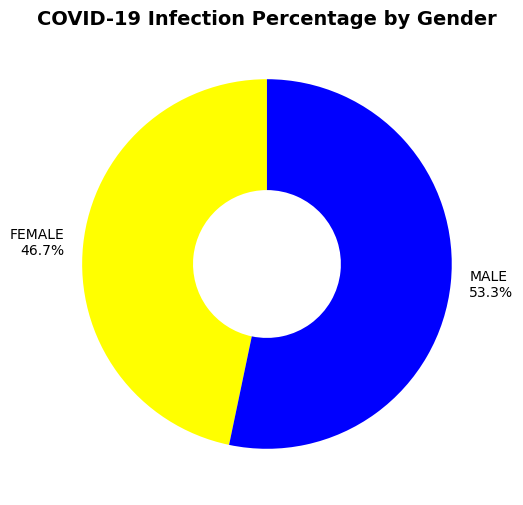

In [21]:
# Define data

labels = ['FEMALE\n46.7%', 'MALE\n53.3%']
values = [263, 300]

# Create donut chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(values, labels=labels, wedgeprops=dict(width=0.6), colors=['YELLOW', 'BLUE'],startangle=90)
ax.set_title("COVID-19 Infection Percentage by Gender", fontsize=14, fontweight='bold')

plt.savefig('C:/Users/SAMIR/Desktop/database/COVID-19 Infection Percentage by Gender.png', bbox_inches='tight')
plt.show()

### Men had a higher infection rate compared to women

# 





### Further analysis to examine the infection percentage among different age groups

In [22]:
covid_age=pd.read_sql( '''
SELECT p.AGE,COUNT(r.PATIENTID) AS COUNT
FROM PATIENTS P JOIN REQUISITIONS r ON p.PATIENTID = r.PATIENTID
WHERE RESULT >= 1 AND TESTID = '1053'
GROUP BY AGE;

''',connection)

#### I will categorize patients ages into age groups to facilitate the analysis of COVID-19 case distribution among various age

In [23]:
# age groups
a_1=0
a_17=0
a_30=0
a_45=0
a_65=0

for index, row in covid_age.iterrows():
    age = int(row['AGE'])
    count = int(row['COUNT'])
    if age <17:
        a_1 += count
    elif age >=17 and age<30:
        a_17 += count
    elif age >=30 and age<45:
        a_30 += count
    elif age >=45 and age<65:
        a_45 += count
    elif age >= 65:
        a_65 += count
  
print(f'a_1={a_1},a_17={a_17},a_30={a_30},a_45={a_45},a_65={a_65}' )

a_1=85,a_17=73,a_30=103,a_45=111,a_65=191


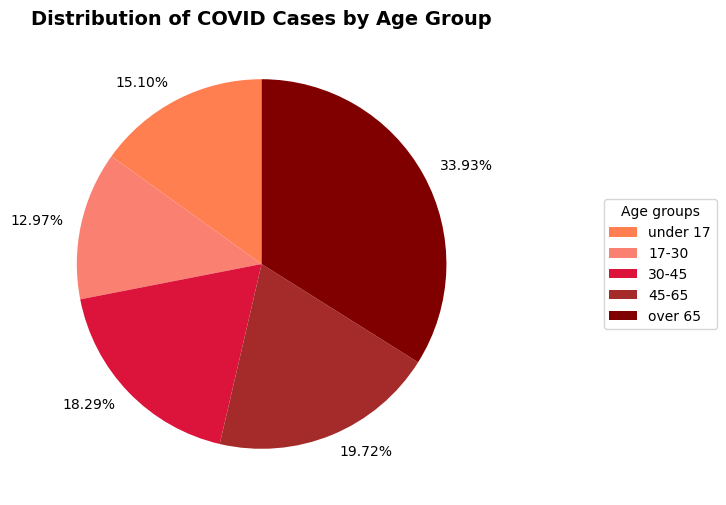

In [24]:
a_groups=[a_1,a_17,a_30,a_45,a_65]

percentage = [f'{a_1/sum(a_groups)*100:.2f}%', 
              f'{a_17/sum(a_groups)*100:.2f}%', 
              f'{a_30/sum(a_groups)*100:.2f}%', 
              f'{a_45/sum(a_groups)*100:.2f}%',
              f'{a_65/sum(a_groups)*100:.2f}%']


c_red = ['Coral', 'Salmon', 'Crimson', 'Brown','Maroon']
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(a_groups, labels=percentage,colors=c_red, startangle=90) 
legend_labels=['under 17','17-30','30-45','45-65','over 65']
plt.legend(title= 'Age groups',loc='right', bbox_to_anchor=(1.5, 0.5),labels=legend_labels)
plt.title('Distribution of COVID Cases by Age Group', fontsize=14, fontweight='bold')

plt.savefig('C:/Users/SAMIR/Desktop/database/Distribution of COVID Cases by Age Group.png', bbox_inches='tight')
plt.show()

## Seniors aged over 65 experienced the highest incidence of COVID-19 infections

In [26]:
connection.close()